## Methodology 
### Turing Study
<insert explanation for Turing study, datasets, and annotations>

In this section, we evaluated each changepoint detection algorithm using the datasets from the Turing study. The code snippets below provide an analysis of an algorithm and it's parameters optimized to find the changepoints closest to the true changepoints and with highest confidence. The purpose of this excercise is to compare the advantages and shortcomings of each algorithm in the KATS package. These insights will be used to determine which algorithm is best suited for Google Mobility data for detecting changepoints during Covid. 

### Import packages

In [ ]:
import json
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from load_dataset import TimeSeries
import warnings
warnings.filterwarnings("ignore")

# import packages for cusum
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData,TimeSeriesChangePoint

### CUSUMDetector

CUSUM is a method to detect an up/down shift of means in a time series. The algorithm is based on likelihood ratio cusum and is used to detect mean changes in Normal Distribution.The typical behavior of the log-likelihood ratio corresponding to a change in the mean of a Gaussian sequence with constant variance is negative drift before and positive drift after the change. So, the change lies in between the value of the log-likelihood ratio and its current minimum value.

The kats package implementation has two main steps:

1. **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point. The next changepoint is the location where the previous CUSUM time series is maximized (or minimized). This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.
2. **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1. The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  If we want to see all the changepoints, we can use the `return_all_changepoints` parameter in `CUSUMDetector` and set it to `True`.

**Underlying assumptions**:

* We assume there is at most one increase change point and at most one decrease change point. You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
* We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.

### Load the datasets

In [15]:
## Load annotated labels 
annotator_df = pd.read_json('annotations.json')
rail_lines_df =  annotator_df[['rail_lines']]
list2d = np.array(rail_lines_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
rail_lines_annotation_lst = list(itertools.chain.from_iterable(list2d))
print("Annotations :", rail_lines_annotation_lst)

## Load rail_lines dataset
ts = TimeSeries.from_json('datasets/rail_lines/rail_lines.json')
print(ts)
rail_lines_df = ts.df
rail_lines_df['date'] =ts.datestr
rail_lines_df['is_CPD'] = np.where(rail_lines_df.t.isin(rail_lines_annotation_lst), 1,0)

Annotations : [10, 25, 10, 26, 10, 25, 25, 26, 25]
TimeSeries(name=rail_lines, n_obs=37, n_dim=1)


### Plot the true annotated labels

     t            V1  date  is_CPD
10  10  9.770744e+05  1990       1
25  25  9.893299e+05  2005       1
26  26  1.062033e+06  2006       1


<Figure size 960x480 with 0 Axes>

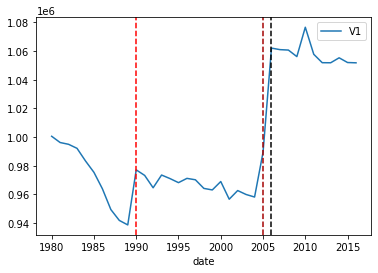

In [16]:
print(rail_lines_df.loc[rail_lines_df['is_CPD']==1])

figure(figsize=(12, 6), dpi=80);
rail_lines_df.plot('date', 'V1')

xposition = rail_lines_df.loc[rail_lines_df['is_CPD']==1][['t']].values

colormap = plt.cm.flag
colors = [colormap(i) for i in np.linspace(0, 1,len(xposition))]
for xc,color in zip(xposition,colors):
    plt.axvline(x=xc, color=color, linestyle='--');

### Prepare data - Create time-series data from pandas dataframe

TimeSeriesData is the basic data structure in Kats to represented univariate and multivariate time series. One of the ways to initiate it is TimeSeriesData(df), where df is a pd.DataFrame object with a "time" column and any number of value columns. Here we construct TimeSeriesData objects for each time series.

Here we are dealing with a Univariate time series

In [336]:
df = rail_lines_df
df['time']= df['date']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
tsd[:5]

time            V1
0 1980-01-01  1.000507e+06
1 1981-01-01  9.961533e+05
2 1982-01-01  9.949100e+05
3 1983-01-01  9.920928e+05
4 1984-01-01  9.833025e+05

### Detector Parameters

The full set of parameters for the `detector` method in `CUSUMDetector`, all of which are optional and have default values, are as follows: 
* **threshold**: float, significance level, **default value = 0.01**;
* **max_iter**: int, maximum iteration in finding the changepoint, **default value = 10**;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change,**default value = 1**;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1, **default value = 0**
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series, **default value = None**
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected. If we do not specify which change directions we are looking for using the change_directions parameter, CUSUMDetector will look for both increases and decreases, **default value = None**. 
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points,**default value = None**. CUSUMDetector can only return one change point in each direction, we can use the interest_window parameter narrow the search window in the case that the input time series contains multiple change points. However, the change point point we return must pass the likelihood ratio test for the entire time series in addition to passing the likelihood ratio test within the interest window 
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison,**default value = None**;
* **magnitude_ratio**: float, comparable ratio,**default value = 1.3**;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression,**default value = 0.5**;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones,**default value = False**.

### Observations

-  CUSUMDetector can only return one change point in each direction. Out of the 3 true annotated change points, only the change point at year 2005 has been detected as it is significant i.e, it passed the likelihood ratio test for the entire time series in addition to passing the likelihood ratio test within the interest window(if provided as a parameter)

- We can use the interest_window parameter to narrow the search window in the case that the input time series contains multiple change points. However, it must pass the likelihood test for the entire time series as well as within the interest window. The other 2 points did not pass the LRT within the interest window, so these insignificant points weren't detected.

- Point 2005 is significant both at the Time Series and interest window level and detected with a very high confidence of 1.0 at the Time Series level
- Points 2006 and 1990 are insignificant at the interest window level though significant at the Time Series level with a very high confidence. 

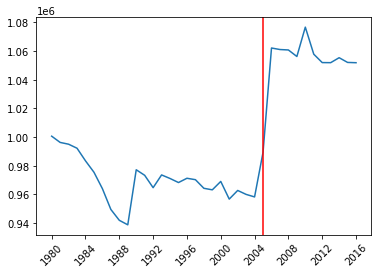

[(TimeSeriesChangePoint(start_time: 2005-01-01 00:00:00, end_time: 2005-01-01 00:00:00, confidence: 1.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7b1810df0>), (TimeSeriesChangePoint(start_time: 1981-01-01 00:00:00, end_time: 1981-01-01 00:00:00, confidence: 0.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7466d5520>)]


In [17]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#The CUSUMDetector detected only point 2005 in increase  direction 
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

## Passing interest window parameter for other points

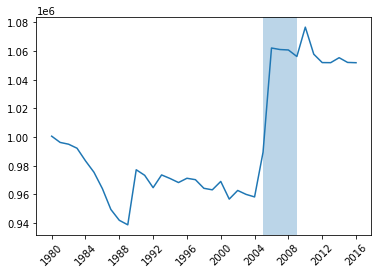

[(TimeSeriesChangePoint(start_time: 2006-01-01 00:00:00, end_time: 2006-01-01 00:00:00, confidence: 0.9999999999989728), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7467a7220>), (TimeSeriesChangePoint(start_time: 2008-01-01 00:00:00, end_time: 2008-01-01 00:00:00, confidence: 0.9999997590836197), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7467a7bb0>)]


In [18]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

change_points = detector.detector(interest_window=[25,30],return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

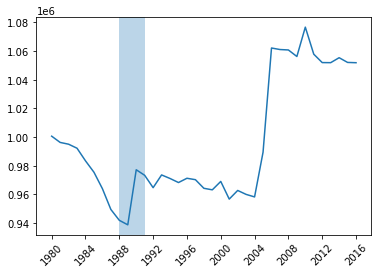

[(TimeSeriesChangePoint(start_time: 1989-01-01 00:00:00, end_time: 1989-01-01 00:00:00, confidence: 0.8736848775962036), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb746c7fe50>), (TimeSeriesChangePoint(start_time: 1990-01-01 00:00:00, end_time: 1990-01-01 00:00:00, confidence: 0.9014021947771731), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7467f9040>)]


In [19]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#In the case below where there is only an increase, it will detect that increase.
change_points = detector.detector(interest_window=[8,12],return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

### Tuning the detector parameters

- **threshold** - The default value of this parameter is 0.01. Changing it to a high value say >= 0.5 and rerunning for the points that were not detected previously detects them now
- **interest_window** - You want to have this window with atleast 2 points before and after the change point, else change point won't be detected. For change point 10, a window of [8,12] works, but [9,12] doesn't.

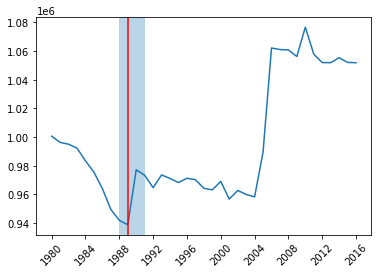

[(TimeSeriesChangePoint(start_time: 1989-01-01 00:00:00, end_time: 1989-01-01 00:00:00, confidence: 0.8736848775962036), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7467f9400>), (TimeSeriesChangePoint(start_time: 1990-01-01 00:00:00, end_time: 1990-01-01 00:00:00, confidence: 0.9014021947771731), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb746c41d30>)]


In [20]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#In the case below where there is only an increase, it will detect that increase.
change_points = detector.detector(interest_window=[8,12],return_all_changepoints=True,threshold=0.5,delta_std_ratio=0.5)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

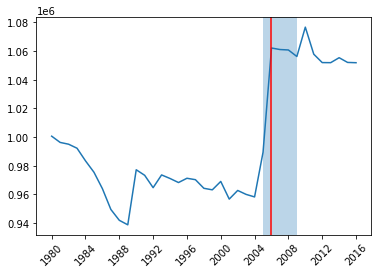

[(TimeSeriesChangePoint(start_time: 2006-01-01 00:00:00, end_time: 2006-01-01 00:00:00, confidence: 0.9999999999989728), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb746c89790>), (TimeSeriesChangePoint(start_time: 2008-01-01 00:00:00, end_time: 2008-01-01 00:00:00, confidence: 0.9999997590836197), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7fb7467f4af0>)]


In [9]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

change_points = detector.detector(interest_window=[25,30],return_all_changepoints=True,threshold=0.9)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

### Combination of interest windows

In [271]:
cpts = [10,25, 26]
after = range(1,20,4)
before = range(1,20,4)
int_window = []
for cp in cpts:
    for windowa in after:
        for windowb in before:
            if (cp+windowa) > 0 and (cp-windowb) > 0:
                int_window.append([cp-windowb,cp+windowa])

In [272]:
# Tune hyperparameters: comparison_window and smoothing_window_size

# Parse list of changepoints and confidence
def parse_CPs(changepoints,df):    
    cp_list = []
    for cp in changepoints:
        changepoint1 = str(cp[0])[34:38]
        changepoint = df.loc[df['time'].isin([changepoint1]),'t'].values[0]
        confidence = str(cp[0])[98:105]
        regression_detected = cp[1].regression_detected
        if regression_detected:
            cp_list.append(str(changepoint)+":"+str(changepoint1))
            #cp_list.append("cp: "+str(changepoint)+" => conf:"+str(confidence)+" => sig: "+str(regression_detected))
    return cp_list

# Hyperparameter tuning for RSD algo
def hp_tuning_cusum(tsd,df):

    # Initialize the detector
    detector = CUSUMDetector(tsd)
    hp_list = []
    hp_value = {}
    for threshold in np.linspace(0,1,100):
        for interest_window in int_window:
            #for min_abs_change in np.linspace(0,1,25):
            change_points = detector.detector(
                threshold=threshold,
                interest_window=interest_window,
                return_all_changepoints=True
                #min_abs_change=min_abs_change
                )
            hp_value = {'threshold': threshold, 'interest_window':interest_window, 'CP': parse_CPs(change_points,df)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [58]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_cusum = hp_tuning_cusum(tsd,df)
print(dataset_hp_cusum.head())
dataset_hp_cusum.to_csv("rail_lines_out.csv")

   threshold interest_window  CP
0        0.0         [9, 11]  []
1        0.0         [5, 11]  []
2        0.0         [1, 11]  []
3        0.0         [9, 15]  []
4        0.0         [5, 15]  []


### Hyperparameter tuning of threshold and interest_window

The true changepoints 2005, 2006 and 1990 are detected for the following parameters:
- cp '26:2006' is detected only when threshold is between 0.3 to 1.0 (inclusive) with window size having 1 point before and atleast 4 points after the cp. If the window size is too wide or too narrow, change point is not detected. Only window range [25,30] to [25, 43] detects this changepoint. 

- cp '25:2005' is detected for all thresholds from 0.01 to 1. Most of the interest windows detects this point by default without needing any hyper parameter tuning.

- cp '10:1990' is detected for threshold ranging between 0.7 to 1 (inclusive). Window that is successul in detecting the changepoint has 1 point before the cp and atleast 4 points after cp upto 13 points. For example, for a cp 10, window [9,14] to [9,23] is successful. 

**In order to choose the optimum threshold, we can choose 0.7 and above. Interest window should be 1 point before and atleast 4 points after cp upto 12 points after cp. **

In [289]:
windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['10:1990']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()
print(df1)

windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['26:2006']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()
print(df1)

windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['25:2005']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()
print(df1)

  interest_window          CP threshold     
                                    min  max
0         (9, 15)  (10:1990,)  0.606061  1.0
1         (9, 19)  (10:1990,)  0.353535  1.0
2         (9, 23)  (10:1990,)  0.414141  1.0
  interest_window          CP threshold     
                                    min  max
0        (25, 31)  (26:2006,)  0.272727  1.0
1        (25, 35)  (26:2006,)  0.121212  1.0
2        (25, 39)  (26:2006,)  0.090909  1.0
3        (25, 43)  (26:2006,)  0.090909  1.0
   interest_window          CP threshold     
                                     min  max
0          (1, 27)  (25:2005,)  0.010101  1.0
1          (5, 27)  (25:2005,)  0.010101  1.0
2          (8, 30)  (25:2005,)  0.010101  1.0
3          (8, 34)  (25:2005,)  0.010101  1.0
4          (8, 38)  (25:2005,)  0.010101  1.0
5          (8, 42)  (25:2005,)  0.010101  1.0
6          (9, 27)  (25:2005,)  0.010101  1.0
7          (9, 31)  (25:2005,)  0.010101  1.0
8          (9, 35)  (25:2005,)  0.010101  1.0

In [290]:
windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['26:2006'],['10:1990'],['25:2005']])][['interest_window','threshold','CP']]
df1 = windows.groupby(windows['CP'].map(tuple)).agg({'threshold':['min','max'],'interest_window':['min','max']}).reset_index()
print(df1.head())

           CP threshold      interest_window          
                    min  max             min       max
0  (10:1990,)  0.353535  1.0         [9, 15]   [9, 23]
1  (25:2005,)  0.010101  1.0         [1, 27]  [24, 42]
2  (26:2006,)  0.090909  1.0        [25, 31]  [25, 43]


In [291]:
# Plot the results of hyperparameter tuning
import hiplot as hip

cp_hiplot = hip.Experiment.from_csv('rail_lines_out.csv')
cp_hiplot.display()

<IPython.core.display.Javascript object>

### Hyperparameter tuning of delta_std_ratio and min_abs_change

In [292]:
# Hyperparameter tuning for cusum algo
def hp_tuning_cusum1(tsd,df):

    # Initialize the detector
    detector = CUSUMDetector(tsd)
    hp_list = []
    hp_value = {}
    n=len(tsd)
 
    for min_abs_change in np.linspace(0,1,10):
        for delta_std_ratio in np.linspace(0,1,10):
            change_points = detector.detector(
                threshold=0.7,
                interest_window=[9,15],
                return_all_changepoints=True,
                min_abs_change=min_abs_change,
                delta_std_ratio=delta_std_ratio
                )
            hp_value = {'delta_std_ratio':delta_std_ratio,'min_abs_change':min_abs_change, 'CP': parse_CPs(change_points,df)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [293]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_cusum1 = hp_tuning_cusum1(tsd,df)
dataset_hp_cusum1.to_csv("rail_lines_out1.csv")

Here irrespective of the values set for min_abs_change whose default value is 0 and  delta_std_ratio  whose default value is 1, the cp get detected only when threshold is over 0.6

In [294]:
cp_hiplot1 = hip.Experiment.from_csv('rail_lines_out1.csv')
cp_hiplot1.display()

<IPython.core.display.Javascript object>

**Tuning some of the other parameters is not very helpful**